In [2]:
# imports
import numpy as np
import statsmodels.formula.api as smf
from boxoffice.modeling.cleaned_data import X_train, y_train, X_test, y_test
from sklearn.metrics import root_mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

In [19]:
# add the new variables to the data
X_train['opening_wide_revenue'] = y_train
X_test['opening_wide_revenue'] = y_test
X_train['log_opening_wide_revenue'] = np.log(y_train)
X_test['log_opening_wide_revenue'] = np.log(y_test)
X_train['log_budget'] = np.log(X_train['budget'])
X_test['log_budget'] = np.log(X_test['budget'])
X_train['sqrt_wikipedia_pre_release_cumulative_views'] = np.sqrt(X_train['wikipedia_pre_release_cumulative_views'])
X_test['sqrt_wikipedia_pre_release_cumulative_views'] = np.sqrt(X_test['wikipedia_pre_release_cumulative_views'])
X_train['log_wikipedia_pre_release_cumulative_views'] = np.log(X_train['wikipedia_pre_release_cumulative_views'] + 1)
X_test['log_wikipedia_pre_release_cumulative_views'] = np.log(X_test['wikipedia_pre_release_cumulative_views'] + 1)
X_train['log_top_5_trailer_views'] = np.log(X_train['top_5_trailer_views'])
X_test['log_top_5_trailer_views'] = np.log(X_test['top_5_trailer_views'])
X_train['not_friday_opener'] = X_train['release_day_of_week_non_preview'] != 4
X_test['not_friday_opener'] = X_test['release_day_of_week_non_preview'] != 4

X_train['normalized_budget'] = (X_train['budget'] - X_train['budget'].mean()) / X_train['budget'].std()
X_test['normalized_budget'] = (X_test['budget'] - X_test['budget'].mean()) / X_test['budget'].std()
X_train['normalized_wikipedia_pre_release_cumulative_views'] = (X_train['wikipedia_pre_release_cumulative_views'] - X_train['wikipedia_pre_release_cumulative_views'].mean()) / X_train['wikipedia_pre_release_cumulative_views'].std()
X_test['normalized_wikipedia_pre_release_cumulative_views'] = (X_test['wikipedia_pre_release_cumulative_views'] - X_test['wikipedia_pre_release_cumulative_views'].mean()) / X_test['wikipedia_pre_release_cumulative_views'].std()
X_train['normalized_top_5_trailer_views'] = (X_train['top_5_trailer_views'] - X_train['top_5_trailer_views'].mean()) / X_train['top_5_trailer_views'].std()
X_test['normalized_top_5_trailer_views'] = (X_test['top_5_trailer_views'] - X_test['top_5_trailer_views'].mean()) / X_test['top_5_trailer_views'].std()
X_train['normalized_metacritic_before_wide_friday_calculated'] = (X_train['metacritic_before_wide_friday_calculated'] - X_train['metacritic_before_wide_friday_calculated'].mean()) / X_train['metacritic_before_wide_friday_calculated'].std()
X_test['normalized_metacritic_before_wide_friday_calculated'] = (X_test['metacritic_before_wide_friday_calculated'] - X_test['metacritic_before_wide_friday_calculated'].mean()) / X_test['metacritic_before_wide_friday_calculated'].std()

In [4]:
# # write all movies with a log wikipedia pre release cumulative views of less than -5 to a txt
# with open('low_wikipedia_pre_release_cumulative_views.txt', 'w') as f:
#     for index, row in X_train.iterrows():
#         if row['log_wikipedia_pre_release_cumulative_views'] < 2:
#             f.write(f'{row['wikipedia_key']}\n')
#     for index, row in X_test.iterrows():
#         if row['log_wikipedia_pre_release_cumulative_views'] < 2:
#             f.write(f'{row['wikipedia_key']}\n')

In [22]:
# print all columns that start with production_method
print([col for col in X_train.columns if col.startswith("production_method")])

formula = "log_opening_wide_revenue ~ normalized_metacritic_before_wide_friday_calculated + log_top_5_trailer_views + normalized_wikipedia_pre_release_cumulative_views + log_budget : metacritic_before_wide_friday_calculated + in_franchise : metacritic_before_wide_friday_calculated"

# "metacritic_review_count",
# "metacritic_score_calculated",
# "metacritic_monday_before_wide_friday_calculated",
# "metacritic_before_wide_friday_calculated",
# "metacritic_before_first_day_calculated"

# add in the interactions
model_simple_glm = smf.glm(formula=formula, data=X_train).fit()

pred_simple_glm = model_simple_glm.predict(X_test)

pred_simple_glm = np.exp(pred_simple_glm)

print("RMSE:", root_mean_squared_error(y_test, pred_simple_glm))
print(model_simple_glm.summary())

train_pred = model_simple_glm.predict(X_train)
train_pred = np.exp(train_pred)

# print predictions vs actual within training data
training_data = pd.DataFrame(
    {
        "actual": y_train,
        "predicted": train_pred,
        "title": X_train["title"],
        "extra": X_train["normalized_wikipedia_pre_release_cumulative_views"],
    }
)

# write to a file
training_data.to_csv("training_data.csv")

fig = px.scatter(training_data, x="actual", y="predicted", hover_name="title", color="extra")
fig.add_trace(go.Scatter(x=training_data["actual"], y=training_data["actual"], mode="lines", name="y=x"))
fig.update_layout(title="Actual vs Predicted Opening Weekend Revenue", xaxis_title="Actual", yaxis_title="Predicted")

['production_method', 'production_method_Digital_Animation', 'production_method_Live_Action', 'production_method_Stop_Motion_Animation']
RMSE: 23875541.902576424
                    Generalized Linear Model Regression Results                     
Dep. Variable:     log_opening_wide_revenue   No. Observations:                  677
Model:                                  GLM   Df Residuals:                      671
Model Family:                      Gaussian   Df Model:                            5
Link Function:                     Identity   Scale:                         0.34383
Method:                                IRLS   Log-Likelihood:                -596.23
Date:                      Tue, 19 Nov 2024   Deviance:                       230.71
Time:                              11:44:00   Pearson chi2:                     231.
No. Iterations:                           3   Pseudo R-squ. (CS):             0.8891
Covariance Type:                  nonrobust                              

Manual Calculation for Paddington 2
intercept of 1.7098 
normalized metacritic guess is -5.1635 * 2.2 = -11.3597
top 5 trailer views is 8.9 million, the log of that is 6.94939001 minus 9 = -2.05060999 * 0.7008 = -1.4373
guess for normalized wikipedia pre release views is -0.6 * 0.1900 = -0.114
budget is 40 million, the log of that is 17.504 * 88 * 0.0048 = 7.393689
in franchise is 1, so 1 * 88 * 0.0094 = 0.8272
kids fiction is 1, so 1 * 88 * 0.1984 = 17.472

sum of all of these is 1.7098 - 11.3597 - 1.4373 - 0.114 + 7.393689 + 0.8272 + 17.472 = 15.391

take the exponential of 15.391 = 4.83 million

In [23]:
results_df = pd.DataFrame({'title': X_test['title'], 'actual': y_test, 'predicted': pred_simple_glm, 'mpaa_rating': X_test['mpaa_rating'], 'creative_type': X_test['creative_type'], 'budget': X_test['budget'], 'wikipedia_pre_release_cumulative_views': X_test['wikipedia_pre_release_cumulative_views'], 'metacritic_before_wide_friday_calculated': X_test['metacritic_before_wide_friday_calculated'], 'genre': X_test['genre'], 'log_top_5_trailer_views': X_test['log_top_5_trailer_views'], 'sqrt_wikipedia_pre_release_cumulative_views': X_test['sqrt_wikipedia_pre_release_cumulative_views'], 'top_5_trailer_views': X_test['top_5_trailer_views'], 'log_budget': X_test['log_budget'], 'log_wikipedia_pre_release_cumulative_views': X_test['log_wikipedia_pre_release_cumulative_views'], 'log_top_5_trailer_views': X_test['log_top_5_trailer_views'], 'not_friday_opener': X_test['not_friday_opener'], 'production_method': X_test['production_method'], 'normalized_budget': X_test['normalized_budget'], 'normalized_wikipedia_pre_release_cumulative_views': X_test['normalized_wikipedia_pre_release_cumulative_views'], 'normalized_top_5_trailer_views': X_test['normalized_top_5_trailer_views'], 'normalized_metacritic_before_wide_friday_calculated': X_test['normalized_metacritic_before_wide_friday_calculated']})

# plot actual vs predicted
fig = px.scatter(results_df, x='actual', y='predicted', hover_name='title', color='log_wikipedia_pre_release_cumulative_views')
fig.add_trace(go.Scatter(x=results_df['actual'], y=results_df['actual'], mode='lines', name='y=x'))
fig.update_layout(title='Actual vs Predicted Opening Weekend Revenue', xaxis_title='Actual', yaxis_title='Predicted')


In [24]:
# plot residuals
results_df["residual"] = results_df["actual"] - results_df["predicted"]

fig2 = px.scatter(results_df, x="predicted", y="residual", hover_name="title", color="creative_type")
fig2.add_trace(go.Scatter(x=results_df["predicted"], y=[0] * len(results_df), mode="lines", name="y=0"))
fig2.update_layout(title="Residuals vs Predicted Opening Weekend Revenue", xaxis_title="Predicted", yaxis_title="Residual")

/tmp/ipykernel_21092/4292569314.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_21092/4292569314.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,title,actual,predicted,budget,wikipedia_pre_release_cumulative_views,metacritic_before_wide_friday_calculated,top_5_trailer_views
468,Avengers: Endgame,357115007.0,20.721103,400000000.0,8078868.0,79.0,538068656.0
623,Spider-Man: No Way Home,260138569.0,19.572698,200000000.0,6211755.0,72.0,197038432.0
346,Avengers: Infinity War,257698183.0,20.000926,300000000.0,6361008.0,70.0,542667265.0
37,Star Wars Ep. VII: The Force Awakens,247966675.0,20.355435,533200000.0,7308580.0,80.0,191498815.0
294,Star Wars Ep. VIII: The Last Jedi,220009584.0,18.757823,262000000.0,3016480.0,83.0,65764078.0
96,Deadpool & Wolverine,211435291.0,18.542872,200000000.0,2957720.0,62.0,92496312.0
318,Black Panther,202003951.0,19.087149,200000000.0,3504158.0,86.0,158087866.0
496,The Lion King,191770759.0,18.131762,260000000.0,2164436.0,59.0,49977186.0
647,Doctor Strange in the Multiverse of Madness,187420998.0,18.489182,200000000.0,3534041.0,64.0,80431609.0
360,Incredibles 2,182687905.0,18.740027,200000000.0,898943.0,80.0,337879237.0


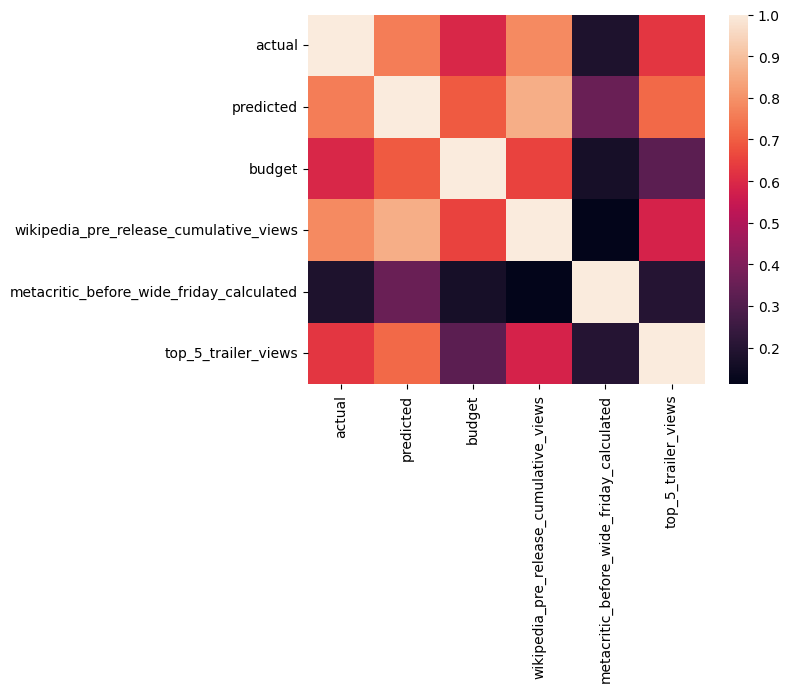

In [8]:
# create a heatmap with the big movies and their various features
all_big_movies = pd.concat([X_train, X_test]).query('opening_wide_revenue > 100000000')

# add actual and predicted values
all_big_movies['actual'] = all_big_movies['opening_wide_revenue']
all_big_movies['predicted'] = model_simple_glm.predict(all_big_movies)

relevant_features = ['actual', 'predicted', 'budget', 'wikipedia_pre_release_cumulative_views', 'metacritic_before_wide_friday_calculated', 'top_5_trailer_views']

sns.heatmap(all_big_movies[relevant_features].corr())

display_features = ['title', 'actual', 'predicted', 'budget', 'wikipedia_pre_release_cumulative_views', 'metacritic_before_wide_friday_calculated', 'top_5_trailer_views']

# create a table of the big movies and their values
all_big_movies[display_features].sort_values('actual', ascending=False)